In [1]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.deserializers import CSVDeserializer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# Session setup
session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
region = session.boto_region_name
xgb_image = sagemaker.image_uris.retrieve('xgboost', region, version='1.7-1')

# Data inputs (reused throughout)
train_input = TrainingInput(s3_data=f's3://{bucket}/data/processed/train/', content_type='text/csv')
val_input = TrainingInput(s3_data=f's3://{bucket}/data/processed/validation/', content_type='text/csv')

# Column names for reading headerless CSVs
col_names = ['Lapsed', 'Distribution_channel', 'Seniority', 'Policies_in_force', 
             'Max_policies', 'Max_products', 'Payment', 'Premium', 'Cost_claims_year',
             'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Type_risk', 
             'Area', 'Second_driver', 'Year_matriculation', 'Power', 'Cylinder_capacity',
             'Value_vehicle', 'N_doors', 'Type_fuel', 'Length', 'Weight', 'Age', 
             'Years_driving', 'Customer_tenure_days']

print(f"Bucket: {bucket}")
print(f"Region: {region}")
print(f"XGBoost image: {xgb_image}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Bucket: sagemaker-us-east-1-360138725243
Region: us-east-1
XGBoost image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1


In [ ]:
# ============================================
# PART 1: BASELINE MODEL 
# ============================================

xgb_baseline = Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/models/',
    sagemaker_session=session,
    base_job_name='insurance-lapse-baseline'
)

xgb_baseline.set_hyperparameters(
    objective='binary:logistic',
    num_round=200,
    max_depth=5,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=4,
    eval_metric='auc'
)

xgb_baseline.fit({'train': train_input, 'validation': val_input})
print("Baseline training complete!")

INFO:sagemaker:Creating training-job with name: insurance-lapse-baseline-2026-02-12-15-18-48-636


2026-02-12 15:18:50 Starting - Starting the training job...
2026-02-12 15:19:04 Starting - Preparing the instances for training...
2026-02-12 15:19:27 Downloading - Downloading input data...
2026-02-12 15:20:12 Downloading - Downloading the training image......
2026-02-12 15:21:18 Training - Training image download completed. Training in progress.../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-12 15:21:23.173 ip-10-2-221-117.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-02-12 15:21:23.240 ip-10-2-221-117.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-02-12:15:21:23:INFO] Imported framework sagemaker_xgboost_container.trai

In [3]:
# Deploy baseline endpoint
baseline_predictor = xgb_baseline.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=CSVDeserializer()
)

print("Baseline endpoint deployed!")

INFO:sagemaker:Creating model with name: insurance-lapse-baseline-2026-02-12-15-22-36-230
INFO:sagemaker:Creating endpoint-config with name insurance-lapse-baseline-2026-02-12-15-22-36-230
INFO:sagemaker:Creating endpoint with name insurance-lapse-baseline-2026-02-12-15-22-36-230


------!Baseline endpoint deployed!


In [4]:
# Load validation data
val_df = pd.read_csv(f's3://{bucket}/data/processed/validation/validation.csv', 
                     header=None, names=col_names)

val_y = val_df['Lapsed'].values
val_X = val_df.drop(columns=['Lapsed'])

# Get probability predictions
predictions = []
batch_size = 500

for i in range(0, len(val_X), batch_size):
    batch = val_X.iloc[i:i+batch_size]
    csv_batch = batch.to_csv(header=False, index=False)
    response = baseline_predictor.predict(csv_batch)
    predictions.extend([float(p[0]) for p in response])

pred_probs = np.array(predictions)

print(f"Got {len(pred_probs):,} predictions")
print(f"Probability range: {pred_probs.min():.4f} to {pred_probs.max():.4f}")
print(f"Mean probability: {pred_probs.mean():.4f}")

Got 21,111 predictions
Probability range: 0.0010 to 0.9987
Mean probability: 0.3701


In [7]:
# ============================================
# THRESHOLD ANALYSIS
# ============================================

# Baseline classification report at default 0.5 threshold
pred_labels_50 = (pred_probs >= 0.5).astype(int)
print("=== Baseline Results (Threshold = 0.50) ===\n")
print(classification_report(val_y, pred_labels_50, target_names=['Not Lapsed', 'Lapsed']))

# Test multiple thresholds
thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.70]

print("\n=== Threshold Comparison ===\n")
print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Flagged':>10} {'Caught':>10} {'Missed':>10}")
print("-" * 75)

for t in thresholds:
    pred = (pred_probs >= t).astype(int)
    tp = ((pred == 1) & (val_y == 1)).sum()
    fp = ((pred == 1) & (val_y == 0)).sum()
    fn = ((pred == 0) & (val_y == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{t:>10.2f} {precision:>10.2%} {recall:>10.2%} {f1:>10.2%} {tp+fp:>10,} {tp:>10,} {fn:>10,}")

=== Baseline Results (Threshold = 0.50) ===

              precision    recall  f1-score   support

  Not Lapsed       0.93      0.80      0.86     16744
      Lapsed       0.50      0.77      0.61      4367

    accuracy                           0.79     21111
   macro avg       0.72      0.78      0.73     21111
weighted avg       0.84      0.79      0.81     21111


=== Threshold Comparison ===

 Threshold  Precision     Recall         F1    Flagged     Caught     Missed
---------------------------------------------------------------------------
      0.20     31.03%     96.98%     47.02%     13,647      4,235        132
      0.25     33.64%     95.49%     49.76%     12,395      4,170        197
      0.30     36.13%     92.86%     52.02%     11,223      4,055        312
      0.35     39.17%     90.06%     54.59%     10,042      3,933        434
      0.40     42.29%     86.42%     56.79%      8,924      3,774        593
      0.45     45.98%     82.46%     59.04%      7,831     

In [9]:
baseline_predictor.delete_endpoint()
print("Baseline endpoint deleted!")

INFO:sagemaker:Deleting endpoint configuration with name: insurance-lapse-baseline-2026-02-12-15-22-36-230


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 baseline_predictor.delete_endpoint()                                                         │
│   2 print("Baseline endpoint deleted!")                                                          │
│   3                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/base_predictor.py:527 in delete_endpoint       │
│                                                                                                  │
│   524 │   │   │   │   be deleted. If False, only endpoint will be deleted.                       │
│   525 │   │   """                                                                                │
│   526 │   │   if delete_endpoint_config:                                                         │
│ ❱ 527 │   │   │   self._delete_endpoint_config()                                                 │
│   528 │   │                                                                                      │
│   529 │   │   self.sagemaker_session.delete_endpoint(self.endpoint_name)                         │
│   530                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/base_predictor.py:512 in                       │
│ _delete_endpoint_config                                                                          │
│                                                                                                  │
│   509 │   def _delete_endpoint_config(self):                                                     │
│   510 │   │   """Delete the Amazon SageMaker endpoint configuration"""                           │
│   511 │   │   current_endpoint_config_name = self._get_endpoint_config_name()                    │
│ ❱ 512 │   │   self.sagemaker_session.delete_endpoint_config(current_endpoint_config_name)        │
│   513 │                                                                                          │
│   514 │   def delete_endpoint(self, delete_endpoint_config=True):                                │
│   515 │   │   """Delete the Amazon SageMaker endpoint backing this predictor.                    │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:5007 in delete_endpoint_config      │
│                                                                                                  │
│   5004 │   │   │   │   delete.                                                                   │
│   5005 │   │   """                                                                               │
│   5006 │   │   logger.info("Deleting endpoint configuration with name: %s", endpoint_config_nam  │
│ ❱ 5007 │   │   self.sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_  │
│   5008 │                                                                                         │
│   5009 │   def create_inference_component(                                                       │
│   5010 │   │   self,                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:569 in _api_call                      │
│                                                            

In [ ]:
# ============================================
# AUTOMATED HYPERPARAMETER TUNING
# ============================================

from sagemaker.tuner import (
    HyperparameterTuner,
    ContinuousParameter,
    IntegerParameter
)

# Define the base estimator
xgb_tuning = Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/models/',
    sagemaker_session=session,
    base_job_name='insurance-lapse-tuned'
)

# Fixed hyperparameters (business decisions, not searchable)
xgb_tuning.set_hyperparameters(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=4
)

# Ranges SageMaker will search
hyperparameter_ranges = {
    'num_round': IntegerParameter(100, 500),
    'max_depth': IntegerParameter(3, 10),
    'eta': ContinuousParameter(0.01, 0.3),
    'subsample': ContinuousParameter(0.5, 1.0),
    'colsample_bytree': ContinuousParameter(0.5, 1.0),
    'min_child_weight': IntegerParameter(1, 10),
    'gamma': ContinuousParameter(0, 5)
}

# Create and launch the tuner
tuner = HyperparameterTuner(
    estimator=xgb_tuning,
    objective_metric_name='validation:auc',
    objective_type='Maximize',
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=4,
    strategy='Bayesian'
)

tuner.fit({'train': train_input, 'validation': val_input})
print("Tuning complete!")

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-260212-1528


.............................................................................................................................!
Tuning complete!


In [12]:
# ============================================
# PART 4: TUNING RESULTS
# ============================================

sm_client = boto3.client('sagemaker')

# Get the most recent tuning job
tuning_jobs = sm_client.list_hyper_parameter_tuning_jobs(
    SortBy='CreationTime',
    SortOrder='Descending',
    MaxResults=1
)

tuning_job_name = tuning_jobs['HyperParameterTuningJobSummaries'][0]['HyperParameterTuningJobName']
tuning_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

best_job = tuning_result['BestTrainingJob']['TrainingJobName']
best_auc = tuning_result['BestTrainingJob']['FinalHyperParameterTuningJobObjectiveMetric']['Value']

print(f"Tuning job: {tuning_job_name}")
print(f"Best training job: {best_job}")
print(f"Best validation AUC: {best_auc:.4f}")

# Get the winning hyperparameters
best_details = sm_client.describe_training_job(TrainingJobName=best_job)
best_hp = best_details['HyperParameters']

print(f"\n=== Best Hyperparameters (Tuned) ===")
print(f"  num_round:        {best_hp.get('num_round')}")
print(f"  max_depth:        {best_hp.get('max_depth')}")
print(f"  eta:              {best_hp.get('eta')}")
print(f"  subsample:        {best_hp.get('subsample')}")
print(f"  colsample_bytree: {best_hp.get('colsample_bytree')}")
print(f"  min_child_weight: {best_hp.get('min_child_weight')}")
print(f"  gamma:            {best_hp.get('gamma')}")

print(f"\n=== Baseline Hyperparameters (Day 4) ===")
print(f"  num_round:        200")
print(f"  max_depth:        5")
print(f"  eta:              0.1")
print(f"  subsample:        0.8")
print(f"  colsample_bytree: 0.8")
print(f"  min_child_weight: (not set)")
print(f"  gamma:            (not set)")


Tuning job: sagemaker-xgboost-260212-1528
Best training job: sagemaker-xgboost-260212-1528-019-c94c7ad3
Best validation AUC: 0.8905

=== Best Hyperparameters (Tuned) ===
  num_round:        256
  max_depth:        10
  eta:              0.09882579656170064
  subsample:        0.9623869740993334
  colsample_bytree: 0.6567008939078207
  min_child_weight: 1
  gamma:            3.081023521973962

=== Baseline Hyperparameters (Day 4) ===
  num_round:        200
  max_depth:        5
  eta:              0.1
  subsample:        0.8
  colsample_bytree: 0.8
  min_child_weight: (not set)
  gamma:            (not set)


In [13]:
# ============================================
# DEPLOY AND EVALUATE TUNED MODEL
# ============================================

# Attach to the best training job from the tuning run
from sagemaker.estimator import Estimator

xgb_tuned = Estimator.attach(best_job)

# Deploy the tuned model
tuned_predictor = xgb_tuned.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=CSVDeserializer()
)

print("Tuned model endpoint deployed!")


2026-02-12 15:39:02 Starting - Found matching resource for reuse
2026-02-12 15:39:02 Downloading - Downloading the training image
2026-02-12 15:39:02 Training - Training image download completed. Training in progress.
2026-02-12 15:39:02 Uploading - Uploading generated training model
2026-02-12 15:39:02 Completed - Resource retained for reuse

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-02-12-15-43-07-395


INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2026-02-12-15-43-07-395
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2026-02-12-15-43-07-395


------!Tuned model endpoint deployed!


In [14]:
# Get predictions from tuned model
tuned_predictions = []
batch_size = 500

for i in range(0, len(val_X), batch_size):
    batch = val_X.iloc[i:i+batch_size]
    csv_batch = batch.to_csv(header=False, index=False)
    response = tuned_predictor.predict(csv_batch)
    tuned_predictions.extend([float(p[0]) for p in response])

tuned_probs = np.array(tuned_predictions)

print(f"Got {len(tuned_probs):,} predictions")
print(f"Probability range: {tuned_probs.min():.4f} to {tuned_probs.max():.4f}")
print(f"Mean probability: {tuned_probs.mean():.4f}")

# Compare both models across thresholds
print(f"\n{'':=<85}")
print(f"BASELINE vs TUNED MODEL COMPARISON")
print(f"{'':=<85}")

thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.70]

print(f"\n{'Threshold':>10} | {'--- Baseline ---':>18} | {'--- Tuned ---':>18} | {'Recall Δ':>9} {'Precision Δ':>12}")
print(f"{'':>10} | {'Prec':>8} {'Recall':>8} | {'Prec':>8} {'Recall':>8} |")
print("-" * 85)

for t in thresholds:
    # Baseline
    b_pred = (pred_probs >= t).astype(int)
    b_tp = ((b_pred == 1) & (val_y == 1)).sum()
    b_fp = ((b_pred == 1) & (val_y == 0)).sum()
    b_fn = ((b_pred == 0) & (val_y == 1)).sum()
    b_prec = b_tp / (b_tp + b_fp) if (b_tp + b_fp) > 0 else 0
    b_rec = b_tp / (b_tp + b_fn) if (b_tp + b_fn) > 0 else 0
    
    # Tuned
    t_pred = (tuned_probs >= t).astype(int)
    t_tp = ((t_pred == 1) & (val_y == 1)).sum()
    t_fp = ((t_pred == 1) & (val_y == 0)).sum()
    t_fn = ((t_pred == 0) & (val_y == 1)).sum()
    t_prec = t_tp / (t_tp + t_fp) if (t_tp + t_fp) > 0 else 0
    t_rec = t_tp / (t_tp + t_fn) if (t_tp + t_fn) > 0 else 0
    
    rec_delta = t_rec - b_rec
    prec_delta = t_prec - b_prec
    
    print(f"{t:>10.2f} | {b_prec:>7.2%} {b_rec:>8.2%} | {t_prec:>7.2%} {t_rec:>8.2%} | {rec_delta:>+8.2%} {prec_delta:>+11.2%}")

Got 21,111 predictions
Probability range: 0.0001 to 0.9999
Mean probability: 0.2844

BASELINE vs TUNED MODEL COMPARISON

 Threshold |   --- Baseline --- |      --- Tuned --- |  Recall Δ  Precision Δ
           |     Prec   Recall |     Prec   Recall |
-------------------------------------------------------------------------------------
      0.20 |  31.03%   96.98% |  40.70%   90.27% |   -6.71%      +9.67%
      0.25 |  33.64%   95.49% |  43.82%   86.95% |   -8.54%     +10.18%
      0.30 |  36.13%   92.86% |  47.31%   83.31% |   -9.55%     +11.18%
      0.35 |  39.17%   90.06% |  50.56%   79.14% |  -10.92%     +11.40%
      0.40 |  42.29%   86.42% |  54.13%   75.25% |  -11.17%     +11.84%
      0.45 |  45.98%   82.46% |  57.69%   71.86% |  -10.60%     +11.71%
      0.50 |  50.03%   77.08% |  61.33%   67.67% |   -9.41%     +11.30%
      0.55 |  54.17%   71.26% |  65.28%   63.50% |   -7.76%     +11.11%
      0.60 |  60.12%   64.58% |  70.06%   59.10% |   -5.47%      +9.94%
      0.70 |  

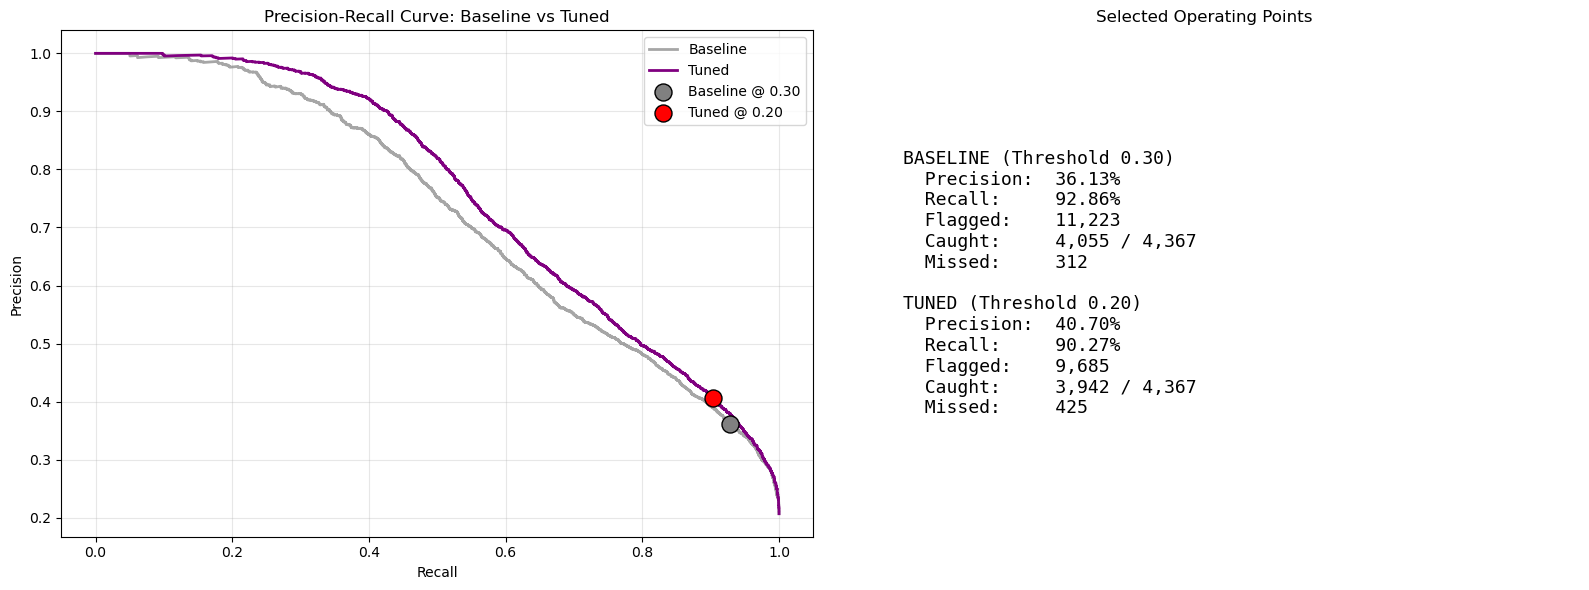

In [15]:
# ============================================
# VISUAL COMPARISON
# ============================================

# Precision-recall curves for both models
b_precision, b_recall, b_thresholds = precision_recall_curve(val_y, pred_probs)
t_precision, t_recall, t_thresholds = precision_recall_curve(val_y, tuned_probs)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Precision-Recall curves overlaid
axes[0].plot(b_recall, b_precision, linewidth=2, label='Baseline', color='gray', alpha=0.7)
axes[0].plot(t_recall, t_precision, linewidth=2, label='Tuned', color='purple')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve: Baseline vs Tuned')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Mark chosen operating points
# Baseline at 0.30
b_pred_30 = (pred_probs >= 0.30).astype(int)
b_tp = ((b_pred_30 == 1) & (val_y == 1)).sum()
b_fp = ((b_pred_30 == 1) & (val_y == 0)).sum()
b_fn = ((b_pred_30 == 0) & (val_y == 1)).sum()
b_p = b_tp / (b_tp + b_fp)
b_r = b_tp / (b_tp + b_fn)
axes[0].scatter(b_r, b_p, color='gray', s=150, zorder=5, edgecolors='black', label='Baseline @ 0.30')

# Tuned at 0.20
t_pred_20 = (tuned_probs >= 0.20).astype(int)
t_tp = ((t_pred_20 == 1) & (val_y == 1)).sum()
t_fp = ((t_pred_20 == 1) & (val_y == 0)).sum()
t_fn = ((t_pred_20 == 0) & (val_y == 1)).sum()
t_p = t_tp / (t_tp + t_fp)
t_r = t_tp / (t_tp + t_fn)
axes[0].scatter(t_r, t_p, color='red', s=150, zorder=5, edgecolors='black', label='Tuned @ 0.20')
axes[0].legend()

# Right: Confusion matrices side by side
axes[1].axis('off')
axes[1].set_title('Selected Operating Points')

summary = f"""
BASELINE (Threshold 0.30)
  Precision:  {b_p:.2%}
  Recall:     {b_r:.2%}
  Flagged:    {b_tp + b_fp:,}
  Caught:     {b_tp:,} / {b_tp + b_fn:,}
  Missed:     {b_fn:,}

TUNED (Threshold 0.20)
  Precision:  {t_p:.2%}
  Recall:     {t_r:.2%}
  Flagged:    {t_tp + t_fp:,}
  Caught:     {t_tp:,} / {t_tp + t_fn:,}
  Missed:     {t_fn:,}
"""
axes[1].text(0.1, 0.5, summary, fontsize=13, fontfamily='monospace',
            verticalalignment='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.savefig('../model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
tuned_predictor.delete_endpoint()
print("Tuned endpoint deleted!")

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2026-02-11-17-41-09-918
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2026-02-11-17-41-09-918


Tuned endpoint deleted!
